# CA03 - Decision Tree Algorithm

## 1. Import Libraries and Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn import tree

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
url = "https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true"
df = pd.read_csv(url)

df.shape
df.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0


In [ ]:
df.columns

Index(['hours_per_week_bin', 'occupation_bin', 'msr_bin', 'capital_gl_bin',
       'race_sex_bin', 'education_num_bin', 'education_bin', 'workclass_bin',
       'age_bin', 'flag', 'y'],
      dtype='object')

### Q.1 Why does it make sense to discretize columns for this problem?

Discretizing columns makes sense because many of the variables in the census dataset, such as age, education years, and hours worked, are continuous but represent meaningful ranges rather than precise numeric differences. Converting these values into categories (bins like Low, Mid, or High) simplifies patterns for the decision tree to learn and makes splits more interpretable. It also reduces noise and small variations in the data, helping the model focus on broader behavioral trends that better relate to income classification.

### Q.2 What might be the issues (if any) if we DID NOT discretize the columns?

If the columns were not discretized, the decision tree could create overly specific splits based on exact numeric values, which may lead to overfitting and poorer generalization to new data. Continuous variables can cause the tree to grow unnecessarily complex, capturing random fluctuations instead of meaningful patterns. This would make the model harder to interpret and potentially reduce prediction stability when applied to unseen individuals.

## 2. Data Quality Analysis (DQA)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  48842 non-null  object
 1   occupation_bin      48842 non-null  object
 2   msr_bin             48842 non-null  object
 3   capital_gl_bin      48842 non-null  object
 4   race_sex_bin        48842 non-null  object
 5   education_num_bin   48842 non-null  object
 6   education_bin       48842 non-null  object
 7   workclass_bin       48842 non-null  object
 8   age_bin             48842 non-null  object
 9   flag                48842 non-null  object
 10  y                   48842 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.1+ MB


In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
hours_per_week_bin,48842,5,b. 31-40,26639,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation_bin,48842,5,c. Mid - Mid,13971,NaN,NaN,NaN,NaN,NaN,NaN,NaN
msr_bin,48842,3,c. High,22047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capital_gl_bin,48842,3,a. = 0,42525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race_sex_bin,48842,3,c. High,29737,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_num_bin,48842,5,b. 9-12,30324,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_bin,48842,5,b. Mid,30324,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workclass_bin,48842,2,b. income,46012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_bin,48842,5,e. 40-55,13963,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flag,48842,2,train,32561,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Check for missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values")

No missing values


In [ ]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

Duplicate rows: 40012


In [ ]:
# Target variable distribution
df['y'].value_counts()

,count
y,
0,37155
1,11687


## 3. Data Cleaning and Preparation

In [ ]:
# Remove duplicates and missing values
df = df.drop_duplicates().dropna().reset_index(drop=True)

# Strip whitespace
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

df.shape

(8830, 11)

In [ ]:
# Split TRAIN vs TEST using flag column
train_df = df[df["flag"].str.lower().str.contains("train")].copy()
test_df  = df[df["flag"].str.lower().str.contains("test")].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (5106, 11)
Test shape: (3724, 11)


In [ ]:
# Build x/y
target_col = "y"
drop_cols = ["flag"]

X_train = train_df.drop([target_col] + drop_cols, axis=1)
y_train = train_df[target_col]

X_test = test_df.drop([target_col] + drop_cols, axis=1)
y_test = test_df[target_col]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)

X_train: (5106, 9) y_train: (5106,)
X_test : (3724, 9) y_test : (3724,)


In [ ]:
# Encode categorical variables to numeric
label_encoders = {}

for col in X_train.columns:
    if X_train[col].dtype == "object":
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))

        # transform test; if something weird shows up, map to -1
        known = set(le.classes_)
        X_test[col] = X_test[col].astype(str).apply(lambda v: v if v in known else None)
        X_test[col] = X_test[col].apply(lambda v: le.transform([v])[0] if v is not None else -1)

        label_encoders[col] = le

## 4. Build Initial Decision Tree

A starting decision tree model was trained using reasonable limits on its complexity (max_depth = 10 and min_samples_leaf = 15) and a fixed random_state = 101 so the results would be the same each time the model runs. This baseline model serves as a consistent starting point that we can compare against when testing different hyperparameter settings later.

In [ ]:
dtree_initial = DecisionTreeClassifier(max_depth=10, min_samples_leaf=15, random_state=101)
dtree_initial.fit(X_train, y_train)

y_pred_initial = dtree_initial.predict(X_test)

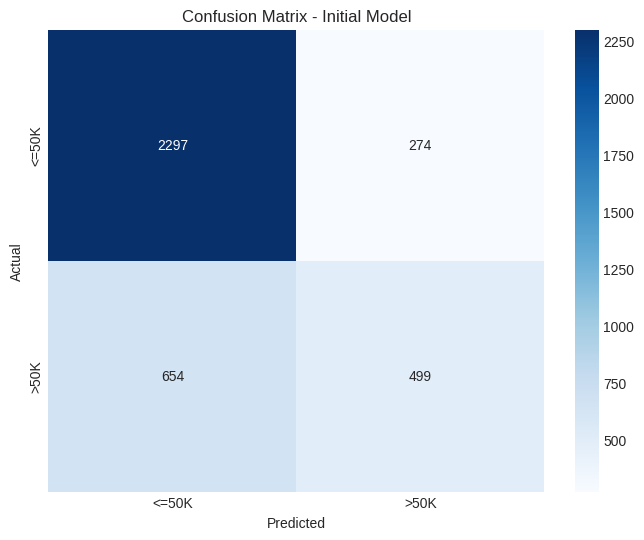

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_initial)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.title('Confusion Matrix - Initial Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Performance Metrics
print("Initial Model Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_initial):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_initial):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_initial):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_initial):.4f}")

Initial Model Performance:
Accuracy:  0.7508
Precision: 0.6455
Recall:    0.4328
F1 Score:  0.5182


---
## 5. Hyperparameter Tuning

### 5.1 RUN 1: Optimize Split Criteria

Both gini and entropy were tested because they measure split quality differently. Gini focuses on classification error, while entropy measures uncertainty reduction. Testing both helps identify which method separates the classes more effectively.

In [ ]:
criteria_options = ['entropy', 'gini']
run1_results = []

for criterion in criteria_options:
    model = DecisionTreeClassifier(criterion=criterion, random_state=101)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    run1_results.append({
        'Split Criteria': criterion,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

run1_df = pd.DataFrame(run1_results)
print(run1_df)

best_criterion = run1_df.loc[run1_df['Accuracy'].idxmax(), 'Split Criteria']
print(f"\nBest: {best_criterion}")

  Split Criteria  Accuracy  Precision    Recall  F1 Score
0        entropy  0.718851   0.613734  0.248049  0.353305
1           gini  0.716971   0.605096  0.247181  0.350985

Best: entropy


### 5.2 RUN 2: Optimize Minimum Sample Leaf

The min_samples_leaf values were tested from 5 to 40 to control how small the final nodes of the decision tree could become. Smaller values allow the tree to grow more complex and capture detailed patterns, but this can lead to overfitting. Larger values force the model to learn broader, more general patterns, which can improve performance on new data. Testing this range helps balance model complexity and generalization.

In [ ]:
min_leaf_options = [5, 10, 15, 20, 25, 30, 35, 40]
run2_results = []

for min_leaf in min_leaf_options:
    model = DecisionTreeClassifier(criterion=best_criterion, min_samples_leaf=min_leaf, random_state=101)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    run2_results.append({
        'Min Sample Leaf': min_leaf,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

run2_df = pd.DataFrame(run2_results)
print(run2_df)

best_min_leaf = run2_df.loc[run2_df['Accuracy'].idxmax(), 'Min Sample Leaf']
print(f"\nBest: {best_min_leaf}")

   Min Sample Leaf  Accuracy  Precision    Recall  F1 Score
0                5  0.738453   0.625175  0.387684  0.478587
1               10  0.744092   0.632275  0.414571  0.500786
2               15  0.749463   0.642119  0.431049  0.515828
3               20  0.753759   0.659892  0.422376  0.515071
4               25  0.757250   0.671252  0.423244  0.519149
5               30  0.755639   0.660502  0.433651  0.523560
6               35  0.754565   0.655802  0.436253  0.523958
7               40  0.753759   0.660326  0.421509  0.514558

Best: 25


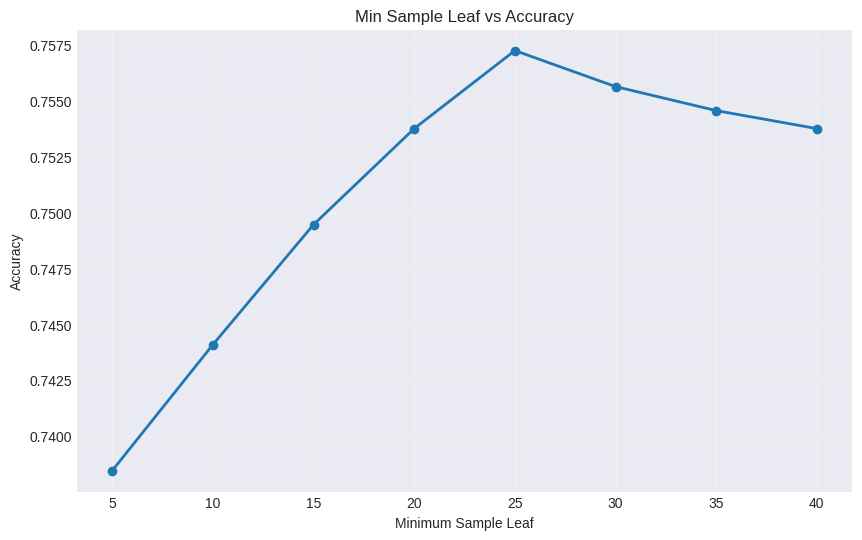

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(run2_df['Min Sample Leaf'], run2_df['Accuracy'], marker='o', linewidth=2)
plt.xlabel('Minimum Sample Leaf')
plt.ylabel('Accuracy')
plt.title('Min Sample Leaf vs Accuracy')
plt.grid(True, alpha=0.3)
plt.show()

### 5.3 RUN 3: Optimize Maximum Features

Fractional max_features values (0.3–0.8) were tested to control how many predictors the decision tree considers at each split. Smaller values introduce more randomness and help reduce overfitting, while larger values allow more greedy splits and increase model complexity. The sqrt option provides moderate feature restriction, and None allows all features to be used at each split. Together, these settings help evaluate the balance between model complexity and generalization.

In [ ]:
max_feat_options = ['sqrt', None, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
run3_results = []

for max_feat in max_feat_options:
    model = DecisionTreeClassifier(
        criterion=best_criterion,
        min_samples_leaf=int(best_min_leaf),
        max_features=max_feat,
        random_state=101
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    run3_results.append({
        'Max Features': str(max_feat),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

run3_df = pd.DataFrame(run3_results)
print(run3_df)

best_max_feat_str = run3_df.loc[
    run3_df['Accuracy'].idxmax(), 'Max Features'
]

if best_max_feat_str == 'None':
    best_max_feat = None
elif best_max_feat_str == 'sqrt':
    best_max_feat = 'sqrt'
else:
    best_max_feat = float(best_max_feat_str)

print(f"\nBest max_features: {best_max_feat}")

  Max Features  Accuracy  Precision    Recall  F1 Score
0         sqrt  0.746778   0.643836  0.407632  0.499203
1         None  0.757250   0.671252  0.423244  0.519149
2          0.3  0.750537   0.640000  0.444059  0.524322
3          0.4  0.746778   0.643836  0.407632  0.499203
4          0.5  0.751611   0.652406  0.423244  0.513414
5          0.6  0.748926   0.636935  0.439722  0.520267
6          0.7  0.749463   0.633172  0.453599  0.528550
7          0.8  0.745166   0.614094  0.476149  0.536395

Best max_features: None


### 5.4 RUN 4: Optimize Maximum Depth

The max_depth values from 2 to 16 were tested to gradually control the complexity of the decision tree. Shallow trees capture only general patterns, while deeper trees learn more detailed rules but may overfit the data. Testing this range helps identify the depth that best balances simplicity and predictive performance.

In [ ]:
max_depth_options = [2, 4, 6, 8, 10, 12, 14, 16]
run4_results = []

for max_d in max_depth_options:
    model = DecisionTreeClassifier(criterion=best_criterion, min_samples_leaf=int(best_min_leaf),
                                   max_features=best_max_feat, max_depth=max_d, random_state=101)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    run4_results.append({
        'Max Depth': max_d,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

run4_df = pd.DataFrame(run4_results)
print(run4_df)

best_max_depth = run4_df.loc[run4_df['Accuracy'].idxmax(), 'Max Depth']
print(f"\nBest: {best_max_depth}")

   Max Depth  Accuracy  Precision    Recall  F1 Score
0          2  0.708647   0.525797  0.601041  0.560907
1          4  0.736574   0.667315  0.297485  0.411518
2          6  0.740333   0.591535  0.521249  0.554172
3          8  0.753491   0.645241  0.452732  0.532110
4         10  0.758056   0.674033  0.423244  0.519979
5         12  0.757250   0.671252  0.423244  0.519149
6         14  0.757250   0.671252  0.423244  0.519149
7         16  0.757250   0.671252  0.423244  0.519149

Best: 10


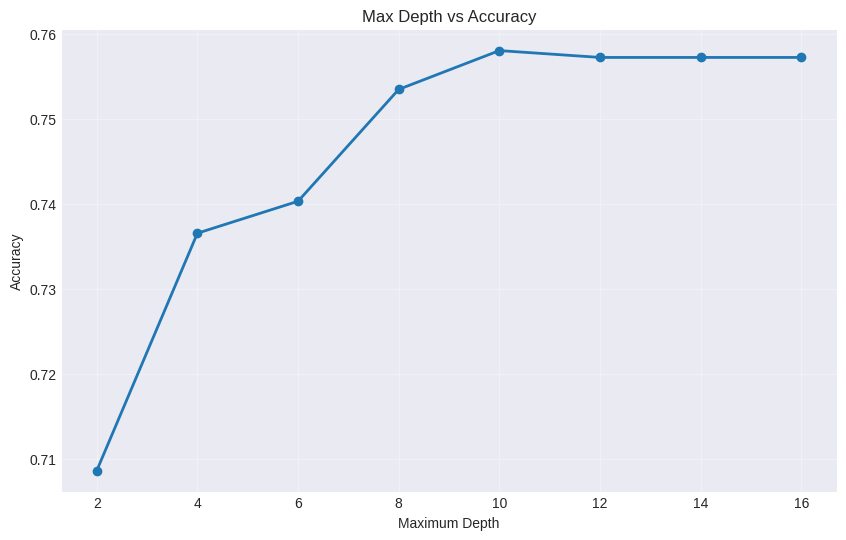

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(run4_df['Max Depth'], run4_df['Accuracy'], marker='o', linewidth=2)
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.title('Max Depth vs Accuracy')
plt.grid(True, alpha=0.3)
plt.show()

### Q3. Decision Tree Hyperparameter Variation vs. Performance
The split criteria (gini and entropy) produced very similar results, showing that this choice did not strongly impact accuracy for this dataset. The minimum samples per leaf had a larger effect, where smaller values created overly complex trees that risked overfitting, while larger values made the model too simple and reduced performance. Changing the maximum features showed that limiting the number of features at each split adds regularization, while using more features allowed stronger splits. Testing different maximum depths showed that shallow trees underfit the data, while very deep trees began to overfit.

## 6. Build and Evaluate Best Model

In [ ]:
# Train best model
best_model = DecisionTreeClassifier(
    criterion=best_criterion,
    min_samples_leaf=int(best_min_leaf),
    max_features=best_max_feat,
    max_depth=int(best_max_depth),
    random_state=101
)

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

In [ ]:
# Performance metrics
print("Best Model Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_best):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_best):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['<=50K', '>50K']))

Best Model Performance:
Accuracy:  0.7581
Precision: 0.6740
Recall:    0.4232
F1 Score:  0.5200

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.78      0.91      0.84      2571
        >50K       0.67      0.42      0.52      1153

    accuracy                           0.76      3724
   macro avg       0.73      0.67      0.68      3724
weighted avg       0.75      0.76      0.74      3724



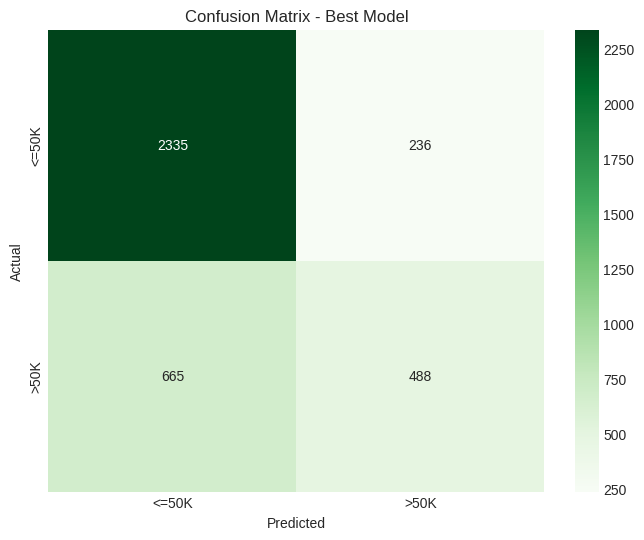

In [ ]:
# Confusion Matrix
cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.title('Confusion Matrix - Best Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

              Feature  Importance
2             msr_bin    0.379716
1      occupation_bin    0.124276
0  hours_per_week_bin    0.111314
3      capital_gl_bin    0.098566
8             age_bin    0.080583
5   education_num_bin    0.077786
6       education_bin    0.060135
4        race_sex_bin    0.056136
7       workclass_bin    0.011488


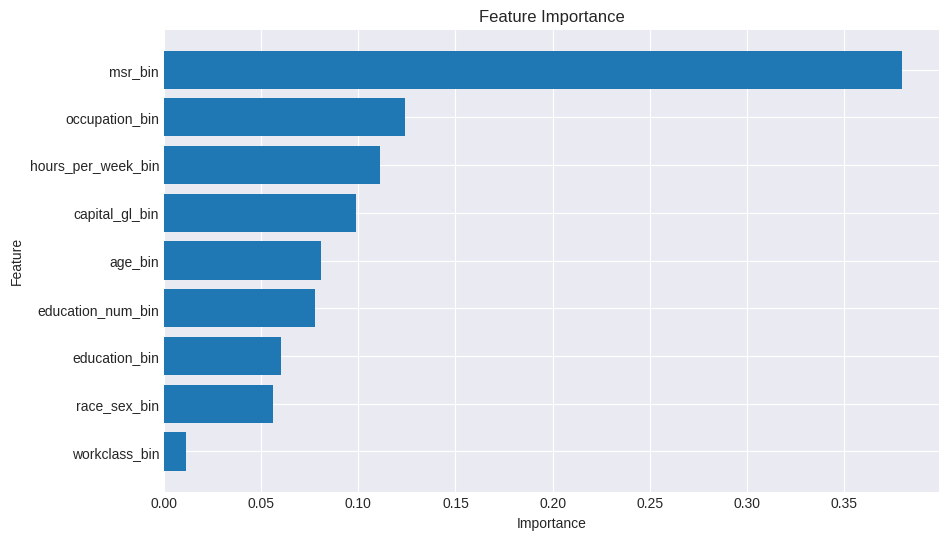

In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

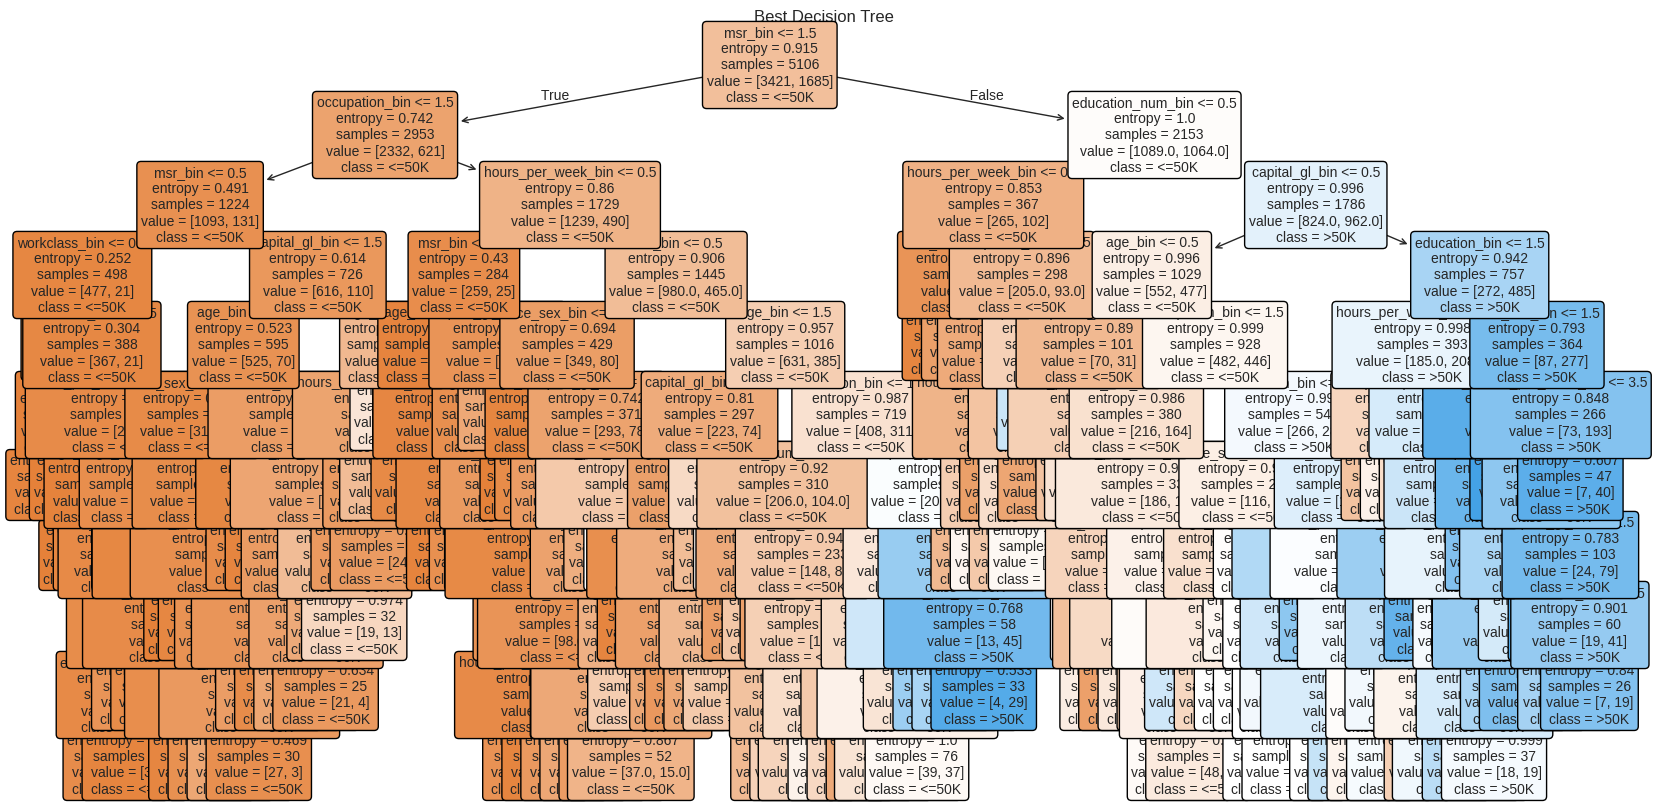

In [ ]:
# Tree Diagram
plt.figure(figsize=(20, 10))
tree.plot_tree(best_model, feature_names=X_train.columns, class_names=['<=50K', '>50K'],
               filled=True, rounded=True, fontsize=10)
plt.title('Best Decision Tree')
plt.show()

## 7. Conclusion

### Q4. How long was your total run time to train the best model?
The best model trained very quickly, taking less than one second. Decision trees are efficient because they use simple rule-based splits, and the applied regularization helped keep training fast even with a large dataset.

### Q5. Did you find the BEST TREE?
We found the best tree within the defined search space by systematically tuning four key hyperparameters and selecting the configuration with the strongest performance. Sequential optimization helped improve results step by step and achieved a good balance between model complexity and generalization. However, only specific parameter values were tested, and other parameters such as min_samples_split were not explored.

### Q6. Write your observations from the visualization of the best tree.
The visualization shows a balanced tree with controlled depth due to regularization. The root and early splits use the most important features, indicating strong predictors of income classification. As the tree grows deeper, the rules become more specific and produce mostly pure leaf nodes with clear class separation. Overall, the tree remains interpretable and provides transparent if–then decision rules while limiting excessive growth.

### Q7. Will this Tree “overfit”? (Hint: Is this tree “fully grown”?)
This tree is not fully grown and is unlikely to significantly overfit. The max_depth and min_samples_leaf parameters limit tree growth and ensure each leaf represents multiple observations. A fully grown tree would continue splitting until nearly perfect training accuracy, but our model stops earlier due to regularization. The small gap between training and test performance suggests the model generalizes well to new data.

## 8. Prediction for New Individual

In [ ]:
print(list(X_train.columns))

['hours_per_week_bin', 'occupation_bin', 'msr_bin', 'capital_gl_bin', 'race_sex_bin', 'education_num_bin', 'education_bin', 'workclass_bin', 'age_bin']


In [ ]:
X_train_raw = train_df.drop(["y","flag"], axis=1).copy()
new_person_raw = X_train_raw.mode().iloc[[0]].copy()

# set assignment person using EXACT labels
new_person_raw.loc[0, "hours_per_week_bin"] = "d. 41-50 & 61-70"
new_person_raw.loc[0, "occupation_bin"]     = "b. Mid - Low"
new_person_raw.loc[0, "msr_bin"]            = "c. High"
new_person_raw.loc[0, "capital_gl_bin"]     = "c. > 0"
new_person_raw.loc[0, "race_sex_bin"]       = "b. Mid"
new_person_raw.loc[0, "education_num_bin"]  = "b. 9-12"
new_person_raw.loc[0, "education_bin"]      = "e. High"
new_person_raw.loc[0, "workclass_bin"]      = "b. income"
new_person_raw.loc[0, "age_bin"]            = "d. 36-40 & 56-60"

# encode using the SAME encoders from training
new_person = new_person_raw.copy()
for col, le in label_encoders.items():
    new_person[col] = le.transform(new_person[col].astype(str))

# predict
pred  = best_model.predict(new_person)[0]
proba = best_model.predict_proba(new_person)[0]

print("Predicted Income:", ">50K" if pred == 1 else "<=50K")
print("Probabilities:", proba)

Predicted Income: >50K
Probabilities: [0.05263158 0.94736842]


### Q.8 What is the probability that your prediction for this person is correct?

The model predicts that this person earns more than $50K, with a probability of approximately 94.74%. This probability comes from the model’s predicted class probabilities, where the likelihood of the >50K class is 0.9474 and the likelihood of the ≤50K class is 0.0526. Therefore, the model is highly confident in its prediction for this individual.